In [1]:


import pandas as pd
import numpy as np
import re


import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import sys
from matplotlib.patches import Patch, PathPatch
from matplotlib.ticker import LinearLocator, FormatStrFormatter, AutoMinorLocator
import matplotlib.ticker as mticker

# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
# plt.rcParams['pdf.fonttype'] = 42
# plt.rcParams['hatch.linewidth'] = 0.6


# Draw graph
# Use plotly to draw MPKI vs Nbr for each benchmark
import plotly.express as px

from plotly.subplots import make_subplots
import plotly.graph_objects as go






path = "../results/"

def addDiffArray(a, b):
    if len(a) < len(b):
        c = b.copy()
        c[:len(a)] += a
    else:
        c = a.copy()
        c[:len(b)] += b
    return c

def fmtBytes(size):
    # 2**10 = 1024
    tmp = -size if size < 0 else size
    power = 2**10
    n = 0
    power_labels = {0 : '', 1: 'K', 2: 'M', 3: 'G', 4: 'T'}
    while tmp >= power:
        tmp /= power
        n += 1
    return "%s%d%s" % ("-" if size < 0 else "", tmp, power_labels[n])


def geo_mean(iterable):
    a = np.array(iterable)
    return a.prod()**(1.0/len(a))



## Speedup

In [3]:

configs = [
    # ("3c", "3c_20M"),
    # ("6c", "6c_20M"),
    # ("9c", "9c_20M"),
    # ("0c", "12k_0c_PC1_500M"), ### Original

    # ("0c", "16k_0c_PC1_500M_3"),
    # ("0c", "test_if1"),

    # ("new", "base_5m"), ### New (Revision)

    # ("new_ret", "2dram_nRet_x_5m"), ### New (Revision)
    ("new_ret", "2dram_nRet_x3_5m"), ### New (Revision)
    ("new_ret", "2dram_nRet_x3_nBTB_5m"), ### New (Revision)
    ("new_ret", "2dram_nRet_x4_5m"), ### New (Revision)
    ("new_ret", "2dram_nRet_x4_withBTB_5m"), ### New (Revision)
    ("new_ret", "2dram_nRet_x5_5m"), ### New (Revision)
    ("new_ret", "2dram_nRet_x7_5m"), ### New (Revision)

    # ("new", "2dram_x_5m"), ### New (Revision)

]


dft = pd.DataFrame()
for config in configs:
    df = pd.read_csv(f"all_res_{config[1]}.csv", sep=" ", header=None)
    df.columns = ["bm", "model", "cfg", "stat", "value"]
    dft = pd.concat([dft, df])






ref = ("extage64kscl", configs[0][1])


# Group by benchmark and calculate reduction per model
dft = dft.pivot_table(index=["bm", "model","cfg"], columns="stat", values="value").reset_index()




dft["MPKI_reduction"] = 0.0
dft["IPC_reduction"] = 0.0
dft["Speedup"] = 0.0


# m = "IPC:"
# dftmp["IPC_reduction"] = dftmp.groupby("bm").apply(lambda x: (x[(x["model"] == ref[0])][m].values[0] - x[m]) / x[(x["model"] == ref[0])][m].values[0]).reset_index(drop=True)
# dftmp["Speedup"] = dftmp.groupby("bm").apply(lambda x: x[m] / (x[(x["model"] == ref)][m].values[0]) ).reset_index(drop=True)




dfref = dft[(dft["model"] == ref[0]) & (dft["cfg"] == ref[1])].set_index("bm")

bms = dft["bm"].unique()

models = dft["model"].unique()

print(models)

dftnew = pd.DataFrame()



for cx, c in configs:

    for model in models:


        dftmp = dft[(dft["model"] == model) & (dft["cfg"] == c)]

        if len(dftmp) == 0:
            continue

        dftmp = dftmp.set_index("bm")
        m = "BRANCH_CONDITIONAL_MPKI"
        dftmp.loc[bms,"MPKI_reduction"] = (dfref.loc[bms,m].values - dftmp.loc[bms,m]) / dfref.loc[bms,m].values
        m = "TAGE_MPKI"
        dftmp.loc[bms,"TAGE_MPKI_reduction"] = (dfref.loc[bms,m].values - dftmp.loc[bms,m]) / dfref.loc[bms,m].values
        m = "TAGE_FT_MPKI"
        dftmp.loc[bms,"TAGE_FT_MPKI_reduction"] = (dfref.loc[bms,m].values - dftmp.loc[bms,m]) / dfref.loc[bms,m].values

        # dftmp["MPKI_reduction"] = (dfref[m].values - dftmp[m]) / dfref[m].values


        # df = dft.set_index(["cfg","model","bm"])
        # dft.set_index(["cfg","model","bm"]).loc[c,model,bms]["MPKI_reduction"] = (dfref.loc[bms,m].values - dftmp.loc[bms,m]) / dfref.loc[bms,m].values

        m = "IPC:"
        dftmp.loc[bms,"IPC_reduction"] = (dfref.loc[bms,m].values - dftmp.loc[bms,m]) / dfref.loc[bms,m].values
        dftmp.loc[bms,"Speedup"] = dftmp.loc[bms,m] / dfref.loc[bms,m].values

        # dftmp["IPC_reduction"] = (dfref[m].values - dftmp[m]) / dfref[m].values
        # dftmp["Speedup"] = dftmp[m] / dfref[m].values
        # dft.set_index(["cfg","model","bm"]).loc[c,model,bms]["IPC_reduction"] = (dfref.loc[bms,m].values - dftmp.loc[bms,m]) / dfref.loc[bms,m].values
        # dft.set_index(["cfg","model","bm"]).loc[c,model,bms]["Speedup"] = dftmp.loc[bms,m] / dfref.loc[bms,m].values

        # dft.reset_index(inplace=True)

        # if model == "extage64kscll2" and cx == "0c":
        #     dftmp.loc["renaissance-finagle-http","Speedup"] = 1.0004302287040106

        # print(dftmp.loc["renaissance-finagle-http","Speedup"])
        # print(dftmp.loc["benchbase-tpcc","Speedup"])


        # dftmp.loc[bms,"MPKI_reduction"] = dftmp.groupby("bm").apply(lambda x: (x[(x["model"] == ref[0]) & (x["cfg"] == ref[1])]["MPKI_direction_mispredicts"].values[0] - x["MPKI_direction_mispredicts"]) / x[(x["model"] == ref[0]) & (x["cfg"] == ref[1])]["MPKI_direction_mispredicts"].values[0]).reset_index(drop=True)


        dftmp.reset_index(inplace=True)




        dm = {"model": model, "bm": "Mean", "cfg" : c}
        for metric in dftmp.columns[3:]:
            dm[metric] = dftmp[metric].mean()


        dg = {"model": model, "bm": "GMean", "cfg" : c}
        for metric in dftmp.columns[3:]:
            dg[metric] = geo_mean(dftmp[metric].values)
            # dg[metric] = dftmp[metric].apply(gmean)

    #     dmd = {"Model": name, "Benchmark": "Median" }
    #     for metric in dftmp.columns[2:]:
    #         dmd[metric] = dftmp[metric].median()

    #     dfall = pd.concat([dfall, dftmp, pd.DataFrame([dm,dg,dmd])])
        dftnew = pd.concat([dftnew, dftmp, pd.DataFrame([dm,dg])])


dftnew[dftnew["bm"] == "Mean"]
# dft.groupby
# df["reduction"] = (tage64ksc_mpki - df.loc[df["stat"] == metric, "value"]) / tage64ksc_mpki
# df
# df
# df4.loc[(df4["Benchmark"] == bm) & (df4["Model"] == ref), m].values[0]
#     df4.loc[df4["Benchmark"] == bm, "MPKI Reduction"] = (tage64ksc_mpki - df4.loc[df4["Benchmark"] == bm, m]) / tage64ksc_mpki

['extage512kscl' 'extage512ksclahead' 'extage64kinfscl' 'extage64kscl'
 'llbp' 'llbpnoflush' 'perfectCond']


,bm,model,cfg,BIM_MISPREDICTIONS,BIM_MPKI,BRANCH_CONDITIONAL,BRANCH_CONDITIONAL_BTB_MISS,BRANCH_CONDITIONAL_BTB_MPKI,BRANCH_CONDITIONAL_MISP,BRANCH_CONDITIONAL_MPKI,...,cpu0_STLB_LOAD_MISS,cpu0_STLB_TOTAL_MISS,cycles:,instructions:,target_misses,MPKI_reduction,IPC_reduction,Speedup,TAGE_MPKI_reduction,TAGE_FT_MPKI_reduction
0,Mean,extage64kscl,2dram_nRet_x3_5m,5.863039e+06,11.726079,7.440235e+07,1.800004e+05,0.359964,1.275910e+06,2.551800,...,427865.928571,427865.928571,2.859494e+08,5.000000e+08,135924.285714,0.000000,0.000000,1.000000,0.000000e+00,0.000000e+00
0,Mean,llbp,2dram_nRet_x3_5m,5.863040e+06,11.726079,7.440234e+07,1.800004e+05,0.359964,1.173620e+06,2.347207,...,427856.428571,427856.428571,2.839758e+08,5.000000e+08,135924.285714,0.067554,-0.007043,1.007043,8.766802e-02,8.684922e-02
0,Mean,llbpnoflush,2dram_nRet_x3_5m,5.863039e+06,11.726079,7.440234e+07,1.800004e+05,0.359964,1.165108e+06,2.330207,...,427854.571429,427854.571429,2.839363e+08,5.000000e+08,135924.285714,0.073948,-0.007201,1.007201,9.457750e-02,9.369481e-02
0,Mean,llbp,2dram_nRet_x3_nBTB_5m,5.863040e+06,11.726079,7.440234e+07,1.800004e+05,0.359964,1.173620e+06,2.347207,...,427856.428571,427856.428571,2.839758e+08,5.000000e+08,135924.285714,0.067554,-0.007043,1.007043,8.766802e-02,8.684922e-02
0,Mean,extage512kscl,2dram_nRet_x4_5m,5.863039e+06,11.726079,7.440233e+07,1.800004e+05,0.359964,9.906789e+05,1.981393,...,427855.714286,427855.714286,2.824595e+08,5.000000e+08,135924.285714,0.210760,-0.012589,1.012589,2.548140e-01,2.520020e-01
0,Mean,extage64kinfscl,2dram_nRet_x4_5m,5.863040e+06,11.726080,7.440235e+07,2.392469e+07,47.850000,8.369126e+05,1.673929,...,427856.571429,427856.571429,2.814264e+08,5.000000e+08,135924.285714,0.310858,-0.015999,1.015999,3.709817e-01,3.668659e-01
0,Mean,llbp,2dram_nRet_x4_5m,5.863039e+06,11.726079,7.440234e+07,1.800004e+05,0.359964,1.170239e+06,2.340550,...,427856.642857,427856.642857,2.839920e+08,5.000000e+08,135924.285714,0.070401,-0.006967,1.006967,9.087890e-02,9.001119e-02
0,Mean,llbpnoflush,2dram_nRet_x4_5m,5.863040e+06,11.726080,7.440235e+07,1.800004e+05,0.359964,1.164115e+06,2.328186,...,427856.214286,427856.214286,2.839617e+08,5.000000e+08,135924.285714,0.074852,-0.007090,1.007090,9.554178e-02,9.464658e-02
0,Mean,perfectCond,2dram_nRet_x4_5m,5.863040e+06,11.726081,7.440236e+07,2.392469e+07,47.850000,1.359243e+05,0.271850,...,427853.285714,427853.285714,2.760847e+08,5.000000e+08,135924.285714,0.881185,-0.036103,1.036103,-2.055283e-08,-3.582539e-08
0,Mean,llbp,2dram_nRet_x4_withBTB_5m,5.863039e+06,11.726079,7.440235e+07,2.392469e+07,47.850000,1.181526e+06,2.363057,...,427864.357143,427864.357143,2.841546e+08,5.000000e+08,135924.285714,0.062481,-0.006330,1.006330,8.197453e-02,8.120741e-02


In [8]:
nbr_tot = dftnew.loc[(dftnew["bm"] == "Mean") & (dftnew["model"] == "extage64kscl"), "TOTAL_BR_EXEC"].values[0]
nbr_cond = dftnew.loc[(dftnew["bm"] == "Mean") & (dftnew["model"] == "extage64kscl"), "BRANCH_CONDITIONAL"].values[0]

print(nbr_tot, nbr_cond, nbr_cond / (nbr_tot-nbr_cond))

93511650.42857143 74402354.92857143 3.8935163741945082


In [9]:
(dfref[m].values - dftmp[m]) / dfref[m].values

0    -0.098254
1    -0.092248
2    -0.088863
3    -0.117660
4    -0.075065
5    -0.084817
6    -0.101067
7    -0.106128
8    -0.139130
9    -0.125226
10   -0.141574
11   -0.059016
12   -0.120956
13   -0.123723
Name: IPC:, dtype: float64

In [85]:
dft[(dft["model"] == model) & (dft["cfg"] == c)].set_index("bm")

,model,cfg,BIM_MISPREDICTIONS,BIM_MPKI,BRANCH_CONDITIONAL,BRANCH_CONDITIONAL_BTB_MISS,BRANCH_CONDITIONAL_BTB_MPKI,BRANCH_CONDITIONAL_MISP,BRANCH_CONDITIONAL_MPKI,BRANCH_CONDITIONAL_NUNIQUE,...,Num_unique_taken_branches,TAGE_MISPREDICTIONS,TAGE_MPKI,TOTAL_BR_EXEC,TOTAL_BR_MISP,cycles:,instructions:,MPKI_reduction,IPC_reduction,Speedup
bm,,,,,,,,,,,,,,,,,,,,,
benchbase-tpcc,extage64kscl,9c_20M,421846.000000,21.092299,2.967090e+06,1.085297e+06,54.300000,110730.000000,5.536000,11572.000000,...,28528.000000,110953.000000,5.547650,4.038175e+06,175658.000000,1.595495e+07,2.000000e+07,0.0,0.000000,0.000000
benchbase-twitter,extage64kscl,9c_20M,331432.000000,16.571600,2.703319e+06,5.643370e+05,28.200000,65812.000000,3.291000,10018.000000,...,24695.000000,64996.000000,3.249800,4.069879e+06,138578.000000,1.216250e+07,2.000000e+07,0.0,0.000000,0.000000
benchbase-wikipedia,extage64kscl,9c_20M,282713.000000,14.135649,2.790355e+06,9.119610e+05,45.600000,87945.000000,4.397000,11582.000000,...,28941.000000,81637.000000,4.081850,3.613911e+06,140515.000000,1.645235e+07,2.000000e+07,0.0,0.000000,0.000000
charlie.1006518,extage64kscl,9c_20M,334984.000000,16.749201,2.914754e+06,1.635391e+06,81.800000,121415.000000,6.071000,21589.000000,...,57861.000000,137425.000000,6.871251,3.601083e+06,179831.000000,4.131061e+07,2.000000e+07,0.0,0.000000,0.000000
dacapo-kafka,extage64kscl,9c_20M,27570.000000,1.378500,2.439997e+06,3.636730e+05,18.200000,17289.000000,0.864400,5369.000000,...,13323.000000,13344.000000,0.667200,5.010153e+06,26883.000000,7.330129e+06,2.000000e+07,0.0,0.000000,0.000000
dacapo-spring,extage64kscl,9c_20M,252952.000000,12.647600,3.328979e+06,1.581570e+06,79.100000,82953.000000,4.148000,11647.000000,...,26855.000000,112830.000000,5.641500,3.699098e+06,85990.000000,9.905707e+06,2.000000e+07,0.0,0.000000,0.000000
dacapo-tomcat,extage64kscl,9c_20M,197271.000000,9.863550,3.074036e+06,7.452400e+05,37.300000,44629.000000,2.231000,14542.000000,...,34713.000000,49934.000000,2.496700,3.919317e+06,93370.000000,2.207272e+07,2.000000e+07,0.0,0.000000,0.000000
delta.507252,extage64kscl,9c_20M,153820.000000,7.690999,1.946733e+06,5.624630e+05,28.100000,18558.000000,0.927900,2791.000000,...,7218.000000,24564.000000,1.228200,2.163094e+06,22257.000000,2.962084e+07,2.000000e+07,0.0,0.000000,0.000000
merced.467915,extage64kscl,9c_20M,361882.000000,18.094096,3.029190e+06,1.169206e+06,58.500000,77943.000000,3.897000,13689.000000,...,34215.000000,78303.000000,3.915150,3.434291e+06,114268.000000,2.652410e+07,2.000000e+07,0.0,0.000000,0.000000


In [27]:





# colors = pltlib.cmallcolors
colors =['#00429d', '#73a2c6', '#ffffe0', '#f4777f', '#93003a']
colors=['#00429d', '#2e59a8', '#4771b2', '#5d8abd', '#73a2c6', '#8abccf', '#a5d5d8', '#c5eddf', '#ffffe0']
        # colors = ['#00429d', '#73a2c6', '#ffffe0', '#93003a']



width = 0.7       # the width of the bars: can also be len(x) sequence


#### Submitted
cw=7.2
# cw=12
fs=12
# cw = 22
rows = 1

## rotation 45
fig, axs = plt.subplots(rows, 1, figsize=(cw,cw*0.26*rows), sharex=True, sharey=False)



# fig, axs = plt.subplots(numplots, 1, figsize=(7.2,2.9 * numplots))






bms = [
    ('nodeapp-nodeapp', 'NodeApp'),
    ('mwnginxfpm-wiki', 'PHPWiki'),

    ('benchbase-tpcc', 'TPCC'),
    ('benchbase-twitter', 'Twitter'),
    ('benchbase-wikipedia', 'Wikipedia'),
    ('dacapo-kafka', 'Kafka'),
    ('dacapo-spring', 'Spring'),
    ('dacapo-tomcat', 'Tomcat'),
    ('renaissance-finagle-chirper', 'Chirper'),
    ('renaissance-finagle-http', 'HTTP'),

    ('charlie.1006518', 'Charlie'),
    ('delta.507252', 'Delta'),
    ('merced.467915', 'Merced'),
    ('whiskey.426708', 'Whiskey'),

    # ('GMean', 'GMean'),
    # ('Mean', 'Mean'),
]

_bms = [b[0] for b in bms] + ["Mean"]
_labels = [b[1] for b in bms] + ["Mean"]

# x = [i+0.2 if v in ["Charlie","Delta","Merced","Whiskey"] else i+0.2 if v in ["GMean", "Mean"] else i for i,v in enumerate(_bms)]
x = np.array([x_+0.3 if l in ["GMean", "Mean"] else x_ for x_,l in enumerate(_bms)])




_configs = [

    # "64K-SCL NT",
    "64K TAGE-SCL",
    "Inf BIM",
    "Inf SCL",
    # "infSC NT",
    "Inf TAGE",
    "Inf Bim+TAGE",
    "Inf TAGE-SCL",
    "MTAGE",
]


_configs = [

    # "64K-SCL NT",
    "64K TAGE-SCL",
    # "Inf BIM",
    # "Inf SCL",
    # "infSC NT",
    "Hawkeye",
    # "Hawkeye Inf",


    "Inf TAGE",

    # "MTAGE",
]

    # ("extage64ksclA-anlz-64kTAGE-New3-CH", "64K TAGE-SCL CH"),
    # ("extage64ksclA-anlz-infTAGE-New3-CH", "Inf TAGE-SCL CH"),
    # ("extage64kpaged-v12-New3-CH", "PV 12 TAGE-SCL CH"),






cfg = configs[0][1]
base_cfg = configs[0][1]



models = [
    ("extage64kscl", base_cfg,"64K TSL"),

    # ("llbp", base_cfg,"LLBP"),
    # ("llbpnoflush", base_cfg,"LLBP Opt"),


    ("llbp", "2dram_nRet_x4_withBTB_5m","LLBP"),
    # ("llbp", "2dram_nRet_x5_5m","LLBP"),

    # ("llbp", "2dram_nRet_x4_5m","LLBP"),
    ("llbpnoflush", "2dram_nRet_x4_5m","LLBP-0Lat"),


    # ("llbpnoflush", "2dram_nRet_x3_nBTB_5m","LLBP Opt"),

    ("extage512kscl", "2dram_nRet_x4_5m","512K TSL"),
    # ("extage64kinfscl", "2dram_nRet_x4_5m","Inf TAGE"),
    ("perfectCond", "2dram_nRet_x4_5m","Perfect BP"),

]


    # ("new_ret", "2dram_nRet_x3_5m"), ### New (Revision)
    # ("new_ret", "2dram_nRet_x3_nBTB_5m"), ### New (Revision)
    # ("new_ret", "2dram_nRet_x4_5m"), ### New (Revision)
    # ("new_ret", "2dram_nRet_x4_withBTB_5m"), ### New (Revision)


colors = {
    '64K TAGE-SCL' : '#0a2d2e',
    '64K TSL' : '#0a2d2e',
    "Inf BIM" : '#3e6f70',
    "Inf SCL" : '#6fa1a2',
    "Inf TAGE" : '#9fd3d4',
    "Inf Bim+TAGE" : '#cfe5e6',
    "Inf TAGE-SCL" : '#cfe5e6',
    "512K TSL" : '#cfe5e6',
    "MTAGE" : '#f7f7f7',
    "Perfect BP" : '#f7f7f7',

    '64K TAGE-SCL CH' : '#0a2d2e',
    "Inf TAGE CH" : '#6fa1a2',
    "Inf TAGE-SCL CH" : '#9fd3d4',
    "PV 12 TAGE CH" : '#f7f7f7',
    "PV 12 TAGE" : '#f7f7f7',

    "Hawkeye" : '#093316',
    "Hawkeye Inf" : '#edf8e9',
    "LLBP" : '#093316',
    "LLBP Inf" : '#edf8e9',
    "LLBP Opt" : '#3e6f70',
    "LLBP-0Lat" : '#3e6f70',


}



nbars = len(models)
bar_width = float(1) / float(nbars+0.5)
init_offset = float(-nbars*bar_width) / 2
get_offset = lambda n : init_offset + n * bar_width


# for j in np.arange(1,len(dfs),1):
#     name, df = dfs[j]



ax = axs



m = "Speedup"
# m = "TAGE_MPKI"
# m = "TAGE_FT_MPKI"
# m = "TAGE_FT_MPKI_reduction"
# m = "BRANCH_CONDITIONAL_NUNIQUE"
# m = "Num_unique_taken_branches"
# m = "BRANCH_INDIRECT_CALL_MPKI"
# m = "BTB_MPKI"

for i, model in enumerate(models):

    if m == "Speedup" and i == 0:
        continue


    print(model)
    dftmp = dftnew[(dftnew["model"] == model[0]) & (dftnew["cfg"] == model[1])].set_index("bm")


    # print(tmp)
    # tmp = tmp[tmp["stat"] == stat[0]].set_index("bm")

    print(len(dftmp),model,m,_bms)
    y = dftmp.loc[_bms, m].values



    ax.bar(x+get_offset(i), y, width=bar_width, bottom=0, #hatch=hatches[j],
            color=colors[model[2]], label=model[2],
            align='edge', edgecolor='k',zorder=2.3)






## Grid
ax.yaxis.set_minor_locator(mticker.AutoMinorLocator(2))
# ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(5))
ax.grid(True, which='both')
ax.grid(True, which='minor', linestyle=':')

ax.set_ylabel(m + " [%]", fontsize=fs)


# for container in ax.containers:
#     ax.bar_label(container, fontsize=5, fmt="%.5f", rotation=90)




## Format x-axis
ax.set_xticks(x)
ax.set_xticklabels(_labels, rotation=23, horizontalalignment="center", fontsize=fs-1)
ax.tick_params(axis='x', which='major', pad=0)

## Format y-axis
# ax.set_ylim(top=3.75*1000000, bottom=0)

# if plot_ylog:
#     ax.set_yscale('log')

# ticks = np.arange(1,1.1,0.02)
# # ticks = ax.get_yticks().tolist()

# # ax.yaxis.set_major_locator(mticker.FixedLocator(ticks))
# ax.set_yticks(ticks)
# # print(ticks)
# ax.set_yticklabels([f"{(x-1)*100:.0f}" for x in ticks], fontsize=fs-1)

if "Speedup" in m:
    ax.set_ylim(bottom=0.999, top=1.069)


ax = axs[0] if rows > 1 else axs

handles, labels = ax.get_legend_handles_labels()



# ax.set_title("L2 Instruction Miss Coverage: " + serie)
ax.legend(handles, labels, bbox_to_anchor=(0.5,1.04), loc="upper center", fontsize=fs-1, ncol=8,
            labelspacing=0.05, columnspacing=1.,handletextpad=0.2,borderpad=0.2,frameon=True)

# ax.legend(loc="best", fontsize="9", )
ax.set_xlim(left=x[0]-0.7, right=x[-1]+0.7)

# plot_data_values = False
# if plot_data_values:
#     # reduction relative to python
#     pltlib.add_value_labels(ax, spacing=4)






fig.tight_layout()

fig.subplots_adjust(
                    # left=0.05,
                    # bottom=0.15,
                    # right=0.9,
                    # top=0.95,
                    hspace=0
                    )


fig.savefig("speedup_study.pdf",dpi=300,format="pdf",bbox_inches='tight', pad_inches=0, facecolor="w")
# fig.savefig("performance_study.png",dpi=300,bbox_inches='tight', pad_inches=0, facecolor="w")

('extage64kscl', '2dram_nRet_x3_5m', '64K TSL')
16 ('extage64kscl', '2dram_nRet_x3_5m', '64K TSL') Num_unique_taken_branches ['nodeapp-nodeapp', 'mwnginxfpm-wiki', 'benchbase-tpcc', 'benchbase-twitter', 'benchbase-wikipedia', 'dacapo-kafka', 'dacapo-spring', 'dacapo-tomcat', 'renaissance-finagle-chirper', 'renaissance-finagle-http', 'charlie.1006518', 'delta.507252', 'merced.467915', 'whiskey.426708', 'Mean']
('llbp', '2dram_nRet_x4_withBTB_5m', 'LLBP')
16 ('llbp', '2dram_nRet_x4_withBTB_5m', 'LLBP') Num_unique_taken_branches ['nodeapp-nodeapp', 'mwnginxfpm-wiki', 'benchbase-tpcc', 'benchbase-twitter', 'benchbase-wikipedia', 'dacapo-kafka', 'dacapo-spring', 'dacapo-tomcat', 'renaissance-finagle-chirper', 'renaissance-finagle-http', 'charlie.1006518', 'delta.507252', 'merced.467915', 'whiskey.426708', 'Mean']
('llbpnoflush', '2dram_nRet_x4_5m', 'LLBP-0Lat')
16 ('llbpnoflush', '2dram_nRet_x4_5m', 'LLBP-0Lat') Num_unique_taken_branches ['nodeapp-nodeapp', 'mwnginxfpm-wiki', 'benchbase-tpc

Locator attempting to generate 19130474 ticks ([0.00999999999999912, ..., 191304.74000000017]), which exceeds Locator.MAXTICKS (1000).


KeyboardInterrupt: 

Locator attempting to generate 19130474 ticks ([0.00999999999999912, ..., 191304.74000000017]), which exceeds Locator.MAXTICKS (1000).


Error in callback <function _draw_all_if_interactive at 0x7f8987bbb520> (for post_execute):


KeyboardInterrupt: 

Locator attempting to generate 19130474 ticks ([0.00999999999999912, ..., 191304.74000000017]), which exceeds Locator.MAXTICKS (1000).


('llbp', '2dram_nRet_x4_withBTB_5m', 'LLBP')
16 ('llbp', '2dram_nRet_x4_withBTB_5m', 'LLBP') TAGE_FT_MPKI_reduction ['nodeapp-nodeapp', 'mwnginxfpm-wiki', 'benchbase-tpcc', 'benchbase-twitter', 'benchbase-wikipedia', 'dacapo-kafka', 'dacapo-spring', 'dacapo-tomcat', 'renaissance-finagle-chirper', 'renaissance-finagle-http', 'charlie.1006518', 'delta.507252', 'merced.467915', 'whiskey.426708', 'Mean']
('llbpnoflush', '2dram_nRet_x4_5m', 'LLBP-0Lat')
16 ('llbpnoflush', '2dram_nRet_x4_5m', 'LLBP-0Lat') TAGE_FT_MPKI_reduction ['nodeapp-nodeapp', 'mwnginxfpm-wiki', 'benchbase-tpcc', 'benchbase-twitter', 'benchbase-wikipedia', 'dacapo-kafka', 'dacapo-spring', 'dacapo-tomcat', 'renaissance-finagle-chirper', 'renaissance-finagle-http', 'charlie.1006518', 'delta.507252', 'merced.467915', 'whiskey.426708', 'Mean']
('extage512kscl', '2dram_nRet_x4_5m', '512K TSL')
16 ('extage512kscl', '2dram_nRet_x4_5m', '512K TSL') TAGE_FT_MPKI_reduction ['nodeapp-nodeapp', 'mwnginxfpm-wiki', 'benchbase-tpcc', '

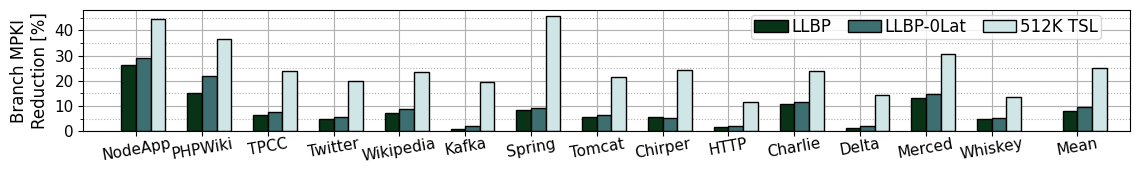

In [26]:





# colors = pltlib.cmallcolors
colors =['#00429d', '#73a2c6', '#ffffe0', '#f4777f', '#93003a']
colors=['#00429d', '#2e59a8', '#4771b2', '#5d8abd', '#73a2c6', '#8abccf', '#a5d5d8', '#c5eddf', '#ffffe0']
        # colors = ['#00429d', '#73a2c6', '#ffffe0', '#93003a']



width = 0.7       # the width of the bars: can also be len(x) sequence

# fwidth=16

# n_subplots = 1

# fwidth=11
# fig, axs = plt.subplots(nrows=n_subplots, ncols=1, sharex=True, figsize=(fwidth, fwidth*2/15*n_subplots))  # width, height

# fwidth=10




#### Submitted
cw=11.5
fs=12
# fs = 20

# #### Presentation
# cw=8
# fs=12
# # fs = 20
fig, axs = plt.subplots(1, 1, figsize=(cw,cw*0.16), sharex=True, sharey=False)


# fig, axs = plt.subplots(numplots, 1, figsize=(7.2,2.9 * numplots))






bms = [
    ('nodeapp-nodeapp', 'NodeApp'),
    ('mwnginxfpm-wiki', 'PHPWiki'),

    ('benchbase-tpcc', 'TPCC'),
    ('benchbase-twitter', 'Twitter'),
    ('benchbase-wikipedia', 'Wikipedia'),
    ('dacapo-kafka', 'Kafka'),
    ('dacapo-spring', 'Spring'),
    ('dacapo-tomcat', 'Tomcat'),
    ('renaissance-finagle-chirper', 'Chirper'),
    ('renaissance-finagle-http', 'HTTP'),

    ('charlie.1006518', 'Charlie'),
    ('delta.507252', 'Delta'),
    ('merced.467915', 'Merced'),
    ('whiskey.426708', 'Whiskey'),

    # ('GMean', 'GMean'),
    # ('Mean', 'Mean'),
]

_bms = [b[0] for b in bms] + ["Mean"]
_labels = [b[1] for b in bms] + ["Mean"]

# x = [i+0.2 if v in ["Charlie","Delta","Merced","Whiskey"] else i+0.2 if v in ["GMean", "Mean"] else i for i,v in enumerate(_bms)]
x = np.array([x_+0.3 if l in ["GMean", "Mean"] else x_ for x_,l in enumerate(_bms)])






cfg = configs[0][1]
base_cfg = configs[0][1]


models = [
    ("extage64kscl", base_cfg,"64K TSL"),

    ("llbp", base_cfg,"LLBP"),
    ("llbpnoflush", base_cfg,"LLBP Opt"),

    # ("llbp", "2dram_nRet_x3_5m","LLBP"),
    # ("llbpnoflush", "2dram_nRet_x3_5m","LLBP Opt"),

    ("llbp", "2dram_nRet_x3_nBTB_5m","LLBP"),
    ("llbpnoflush", "2dram_nRet_x3_nBTB_5m","LLBP-Lat"),

    # ("extage512kscl", base_cfg,"512K TSL"),
    # # ("extage64kinfscl", cfg,"Inf TAGE"),
    # ("perfectCond", base_cfg,"Perfect BP"),

]

models = [
    ("extage64kscl", base_cfg,"64K TSL"),

    # ("llbp", base_cfg,"LLBP"),
    # ("llbpnoflush", base_cfg,"LLBP Opt"),

    # ("llbp", "2dram_nRet_x4_5m","LLBP"),

    ("llbp", "2dram_nRet_x4_withBTB_5m","LLBP"),
    # ("llbp", "2dram_nRet_x5_5m","LLBP"),
    # ("llbp", "2dram_nRet_x7_5m","LLBP"),
    ("llbpnoflush", "2dram_nRet_x4_5m","LLBP-0Lat"),

    # ("llbpnoflush", "2dram_nRet_x3_nBTB_5m","LLBP Opt"),

    ("extage512kscl", "2dram_nRet_x4_5m","512K TSL"),
    # ("extage512ksclahead", "2dram_nRet_x5_5m","512K TSL"),

]


colors = {
    '64K TAGE-SCL' : '#0a2d2e',
    '64K TSL' : '#0a2d2e',
    "Inf BIM" : '#3e6f70',
    "Inf SCL" : '#6fa1a2',
    "Inf TAGE" : '#9fd3d4',
    "Inf Bim+TAGE" : '#cfe5e6',
    "Inf TAGE-SCL" : '#cfe5e6',
    "512K TSL" : '#cfe5e6',
    "MTAGE" : '#f7f7f7',
    "Perfect BP" : '#f7f7f7',

    '64K TAGE-SCL CH' : '#0a2d2e',
    "Inf TAGE CH" : '#6fa1a2',
    "Inf TAGE-SCL CH" : '#9fd3d4',
    "PV 12 TAGE CH" : '#f7f7f7',
    "PV 12 TAGE" : '#f7f7f7',

    "Hawkeye" : '#093316',
    "Hawkeye Inf" : '#edf8e9',
    "LLBP" : '#093316',
    "LLBP Inf" : '#edf8e9',
    "LLBP Opt" : '#3e6f70',
    "LLBP-0Lat" : '#3e6f70',

}




nbars = len(models)
bar_width = float(1) / float(nbars+0.5)
init_offset = float(-nbars*bar_width) / 2
get_offset = lambda n : init_offset + n * bar_width


# for j in np.arange(1,len(dfs),1):
#     name, df = dfs[j]



ax = axs



m = "Speedup"
m = "TAGE_MPKI"
m = "TAGE_FT_MPKI"
m = "TAGE_FT_MPKI_reduction"

for i, model in enumerate(models):

    if i == 0:
        continue


    print(model)
    dftmp = dftnew[(dftnew["model"] == model[0]) & (dftnew["cfg"] == model[1])].set_index("bm")


    # print(tmp)
    # tmp = tmp[tmp["stat"] == stat[0]].set_index("bm")

    print(len(dftmp),model,m,_bms)
    y = dftmp.loc[_bms, m].values



    ax.bar(x+get_offset(i), y, width=bar_width, bottom=0, #hatch=hatches[j],
            color=colors[model[2]], label=model[2],
            align='edge', edgecolor='k',zorder=2.3)





## Grid
ax.yaxis.set_minor_locator(mticker.AutoMinorLocator(2))
# ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(5))
ax.grid(True, which='both')
ax.grid(True, which='minor', linestyle=':')

ax.set_ylabel("Branch MPKI\nReduction [%]", fontsize=fs)

_y = ax.get_yticks()
ax.set_yticks(_y)
ax.set_yticklabels([f"{y*100:.0f}" for y in _y], fontsize=fs-1)

# for container in ax.containers:
#     ax.bar_label(container, fontsize=7, fmt="%.4f", rotation=90)


## Format x-axis
ax.set_xticks(x)
ax.set_xticklabels(_labels, rotation=10, horizontalalignment="center", fontsize=fs-1)
ax.tick_params(axis='x', which='major', pad=0)

ax.set_ylim(bottom=-0.0, top=0.48)



handles, labels = ax.get_legend_handles_labels()



# ax.set_title("L2 Instruction Miss Coverage: " + serie)
ax.legend(handles, labels, bbox_to_anchor=(0.98,1.03), loc="upper right", fontsize=fs, ncol=8,
            labelspacing=0.05, columnspacing=1.,handletextpad=0.2,borderpad=0.2,frameon=True)

# ax.legend(loc="best", fontsize="9", )
ax.set_xlim(left=x[0]-0.8, right=x[-1]+0.8)





fig.tight_layout()

fig.subplots_adjust(
                    # left=0.05,
                    # bottom=0.15,
                    # right=0.9,
                    # top=0.95,
                    hspace=0
                    )


fig.savefig("mpki_study.pdf",dpi=300,format="pdf",bbox_inches='tight', pad_inches=0, facecolor="w")
# fig.savefig("performance_study.png",dpi=300,bbox_inches='tight', pad_inches=0, facecolor="w")